In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import random
import shutil
from IPython import display

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow import GradientTape
from tensorflow import function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow import ones_like, zeros_like
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.random import normal
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dense, Activation, Flatten, MaxPooling2D, Reshape, Conv2D, ReLU,LeakyReLU  

In [2]:
data = "D:\IT\IMT Courses\Deep Learning\GAN\Project\images"

all_images = []
for image in os.listdir(data):
    image_path = os.path.join(data,image)
    all_images.append(image_path)

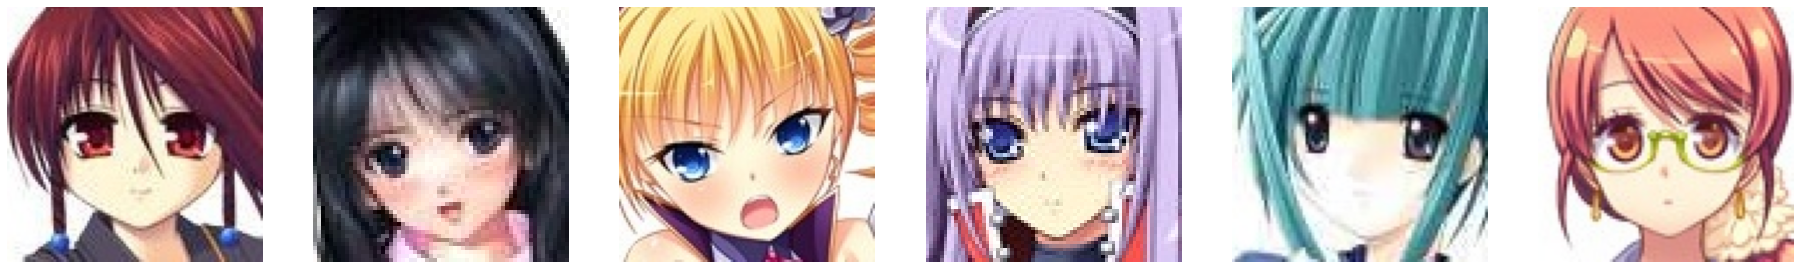

In [3]:
selected_images = random.sample(all_images, 6)

fig, ax = plt.subplots(1, 6, figsize=(32,32))
for i, image_path in enumerate(selected_images):
    img = mpimg.imread(image_path)
    ax[i].imshow(img)
    ax[i].axis('off')

In [4]:
train_data = []
for path in all_images:
    img = load_img(path, target_size=(64, 64))
    img = img_to_array(img)
    train_data.append(img)
train_data = np.array(train_data, dtype='float32')

# Normalize pixel values to the range [-1, 1]
train_data = (train_data - 127.5) / 127.5

train_data = train_data.reshape(train_data.shape[0], 64, 64, 3)

In [6]:
def generator():
    kernel_initializer = RandomNormal(mean=0, stddev=0.02)
    
    generator = Sequential()
    
    generator.add(Dense(7 * 7 * 512, input_dim=100))
    generator.add(ReLU())
    generator.add(Reshape((7, 7, 512)))
    
    generator.add(Conv2DTranspose(256, (4,4), strides=(2,2), kernel_initializer=kernel_initializer, activation='relu'))
    generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), kernel_initializer=kernel_initializer, activation='relu'))
    generator.add(Conv2DTranspose(64, (4,4), strides=(2,2), kernel_initializer=kernel_initializer, activation='relu'))
    generator.add(Conv2D(3, (4,4), activation='tanh'))
    return generator

generator = generator()

(1, 67, 67, 3)


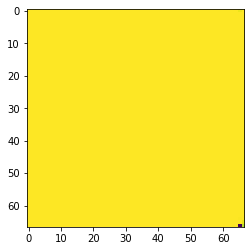

In [117]:
noise = normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])
print(generated_image.shape)

In [157]:
def discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (4,4), strides=(2,2), input_shape=(64,64,3),padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2))
    
    discriminator.add(Conv2D(128, (4,4), strides=(2,2),padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2))
    
    discriminator.add(Conv2D(128, (4,4), strides=(2,2),padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2))
    
    discriminator.add(Conv2D(128, (4,4), strides=(2,2)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(alpha=0.2))

#     discriminator.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    
    return discriminator

discriminator = discriminator()

In [160]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5098567]], shape=(1, 1), dtype=float32)


In [110]:
cross_entropy = BinaryCrossentropy(from_logits=True)

# Define loss functiones
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(ones_like(real_output), real_output)
    fake_loss = cross_entropy(zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss)
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(ones_like(fake_output), fake_output)

# Define optimizer
discriminator_optimizer = Adam()
generator_optimizer = Adam()

In [111]:
epochs = 2
batch_size = 500
noise_dim = 100
num_examples_to_generator = 50
seed = normal([num_examples_to_generator, noise_dim])

In [113]:
def train_step(images):
    # Generate random noise
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images from noise using the generator
        generated_images = generator(noise, training=True)

        # Disciminator output for real images
        real_output = discriminator(images, training=True)
        # Discriminator output for generated images
        fake_output = discriminator(generated_images, training=True)

        # Calculate generator and discriminator loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [114]:
def generat_and_save_images(model, epoch, test_input):
    prediction = model(test_input, training=False)
    
    fig = plt.figure(figsize=(32,32))
    for i in range(prediction.shape[0]):
        plt.subplot(32, 32, i+1)
        plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

In [115]:
def train(data, epochs, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(len(data)).batch(batch_size)
    
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)
        print('number of epoch: ', epoch+1)
        display.clear_output(wait=True)
        generat_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generat_and_save_images(generator, epoch+1, seed)

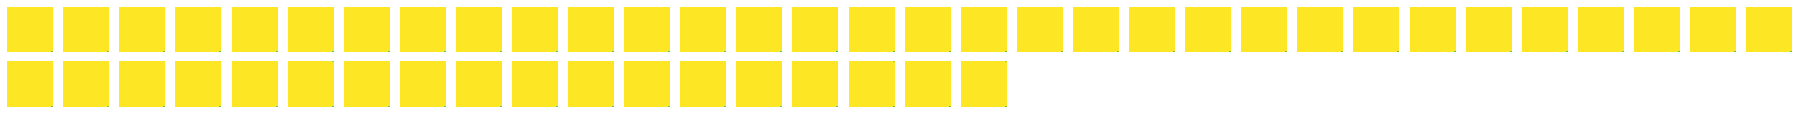

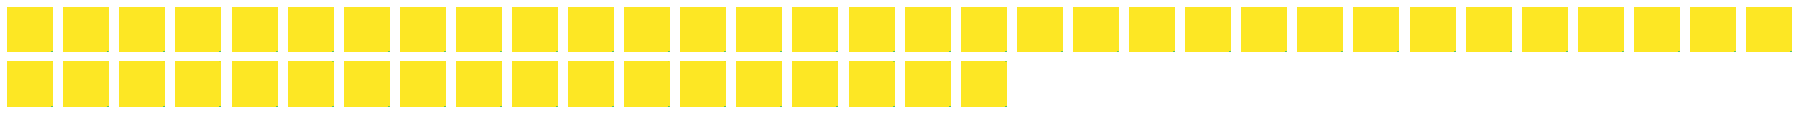

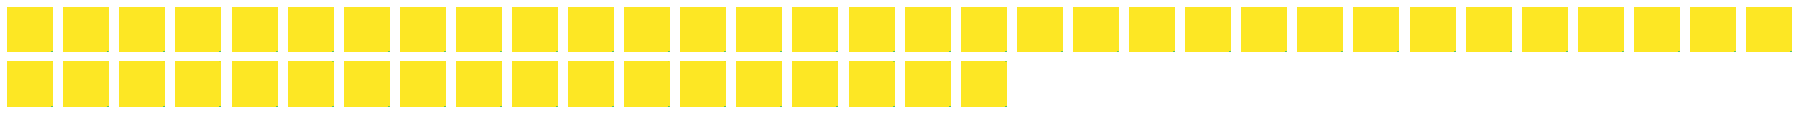

In [116]:
train(train_data, epochs, batch_size)